## Data Preprocessing

In [1]:
import pandas as pd

file_path = r'C:\Users\glawi\OneDrive - Aston University\Dissertation\jupyter file\household_power_consumption.txt'

df = pd.read_csv(file_path, sep=';', 
                 parse_dates={'Datetime': ['Date', 'Time']},  # Combine Date and Time into a single column
                 dayfirst=True,  # Specify that day comes first in the date
                 na_values=['?'],  # Handle missing values represented as '?'
                 low_memory=False)  # Disable low_memory mode to avoid dtype issues


print(df.head())


             Datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


In [2]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Filling in the missing values with the median
df.fillna(df.median(), inplace=True)


Missing values in each column:
 Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [3]:
# Converting the data types for numeric columns
df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']] = df[['Global_active_power', 
    'Global_reactive_power', 'Voltage', 'Global_intensity', 
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].astype(float)

In [4]:
# Creating time-based features
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['Day_of_week'] = df['Datetime'].dt.dayofweek

In [5]:
# Resampling to hourly data
df_hourly = df.resample('H', on='Datetime').mean()


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Normalizing the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_hourly), columns=df_hourly.columns, index=df_hourly.index)



In [7]:
# Feature engineering: Creating lag features and rolling statistics
df_scaled['lag_1'] = df_scaled['Global_active_power'].shift(1)
df_scaled['lag_24'] = df_scaled['Global_active_power'].shift(24)  # Lag of 24 hours (1 day)
df_scaled['lag_168'] = df_scaled['Global_active_power'].shift(168)  # Lag of 168 hours (1 week)
df_scaled['rolling_mean_24'] = df_scaled['Global_active_power'].rolling(window=24).mean()
df_scaled['rolling_std_24'] = df_scaled['Global_active_power'].rolling(window=24).std()

In [8]:
# Droping NaN values caused by lag and rolling calculations to clean the data for modeling
df_scaled.dropna(inplace=True)

# Defining the features (X) and target variable (y) for the model
X = df_scaled.drop(columns=['Global_active_power'])
y = df_scaled['Global_active_power']

# Spliting the data into training and testing sets to evaluate the model's performance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


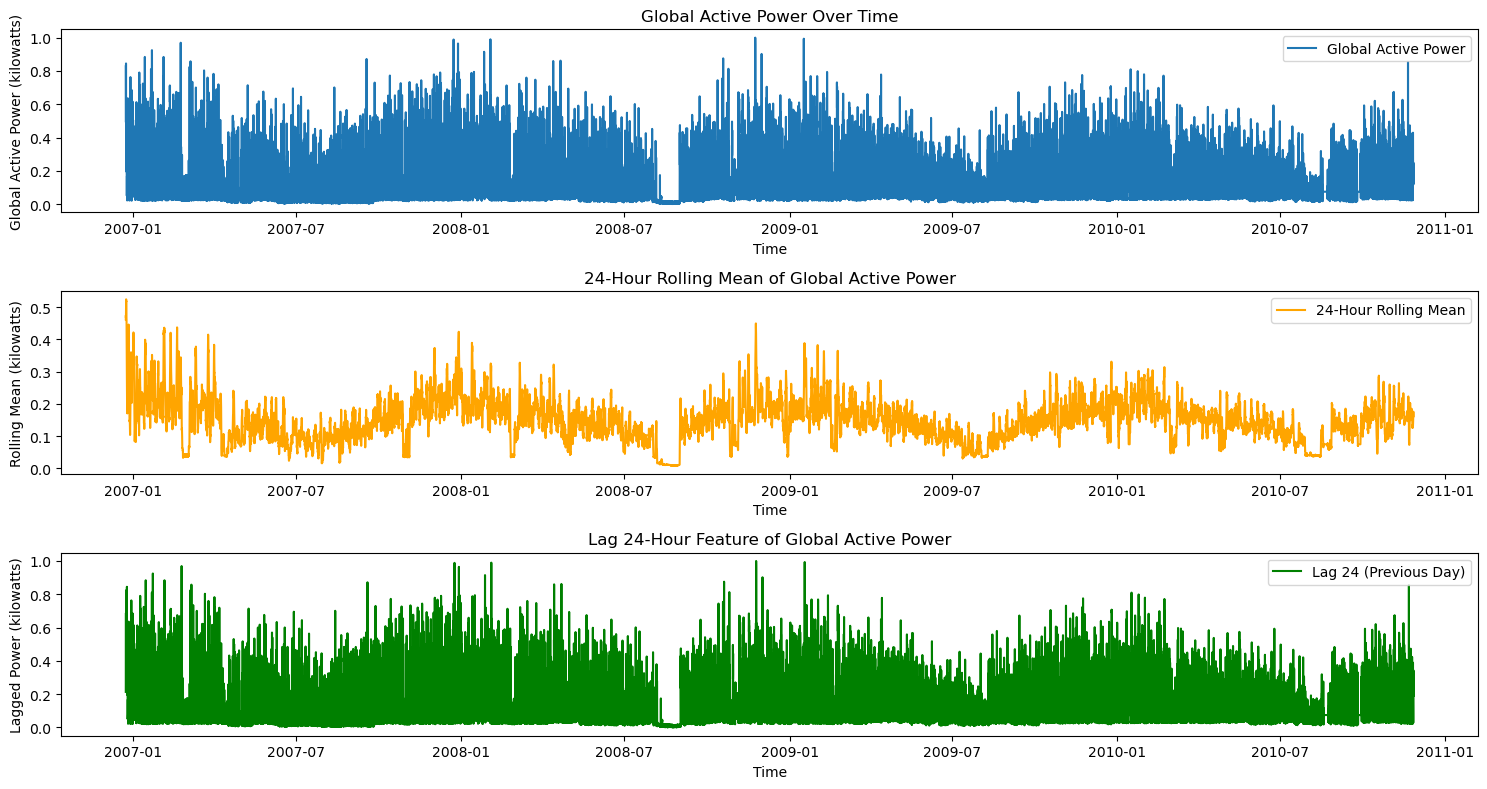

In [9]:
# Visualizing the processed data to better understand the trends and patterns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Ploting Global Active Power
plt.subplot(3, 1, 1)
plt.plot(df_scaled.index, df_scaled['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()

# Ploting Rolling Mean
plt.subplot(3, 1, 2)
plt.plot(df_scaled.index, df_scaled['rolling_mean_24'], label='24-Hour Rolling Mean', color='orange')
plt.title('24-Hour Rolling Mean of Global Active Power')
plt.xlabel('Time')
plt.ylabel('Rolling Mean (kilowatts)')
plt.legend()

# Ploting Lag Feature
plt.subplot(3, 1, 3)
plt.plot(df_scaled.index, df_scaled['lag_24'], label='Lag 24 (Previous Day)', color='green')
plt.title('Lag 24-Hour Feature of Global Active Power')
plt.xlabel('Time')
plt.ylabel('Lagged Power (kilowatts)')
plt.legend()

plt.tight_layout()
plt.show()


## Forecasting Using Hybrid LSTM + SWT Model

## Set a Valid Decomposition Level

In [10]:
import pywt
import numpy as np

# Function to apply Stationary Wavelet Transform (SWT) to the data
def apply_swt(data, wavelet='db1'):
    # Calculating the maximum level based on the length of the data
    max_level = pywt.swt_max_level(len(data))
    
    # Applying SWT with the maximum allowable level to decompose the time series
    coeffs = pywt.swt(data, wavelet, level=max_level)
    approx_coeffs, detail_coeffs = zip(*coeffs)
    return np.array(approx_coeffs), np.array(detail_coeffs)
# Ensureing the data length is even by padding it, as SWT requires even-length data
data = df_scaled['Global_active_power'].values
if len(data) % 2 != 0:
    data = np.append(data, data[-1])  # Pad with the last value to make the length even

# Apply SWT to the padded data with a valid decomposition level
approx_coeffs, detail_coeffs = apply_swt(data)

## Prepareing Data for LSTM Model

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Using the first level of approximate coefficients for training the LSTM model
approx_coeffs_level1 = approx_coeffs[0]  # Selecting the first level of decomposition

# Normalize the data to prepare it for LSTM training
scaler = MinMaxScaler()
scaled_approx_coeffs = scaler.fit_transform(approx_coeffs_level1.reshape(-1, 1))

# Creating sequences for LSTM input, using the past 24 hours to predict the next hour
sequence_length = 24
X, y = [], []
for i in range(len(scaled_approx_coeffs) - sequence_length):
    X.append(scaled_approx_coeffs[i:i + sequence_length])
    y.append(scaled_approx_coeffs[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Spliting the data into training and testing sets (80% train, 20% test) for evaluation
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping data for LSTM input (samples, time steps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Checking the shapes of the training and testing datasets
print(f"X_train shape: {X_train_reshaped.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test_reshaped.shape}, y_test shape: {y_test.shape}")


X_train shape: (27518, 24, 1), y_train shape: (27518, 1)
X_test shape: (6880, 24, 1), y_test shape: (6880, 1)


## Building the LSTM Model

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Building the LSTM model for time-series forecasting
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))  # Output layer to predict the next energy consumption value
model.compile(optimizer='adam', loss='mse')  # Compile the model with mean squared error loss

# Training the model using the training data
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))


Epoch 1/10


c:\Users\glawi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0173 - val_loss: 0.0077
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0111 - val_loss: 0.0046
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 9/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 10/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0030 - val_loss: 0.0021


## Evaluate the LSTM Model

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Generating predictions using the LSTM model
y_pred = model.predict(X_test_reshaped)

# Inverse scaling to return predictions to the original scale for evaluation
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculating RMSE and MAE to assess model performance
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse}, MAE: {mae}")




215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 0.05925799190823058, MAE: 0.041027949713305756


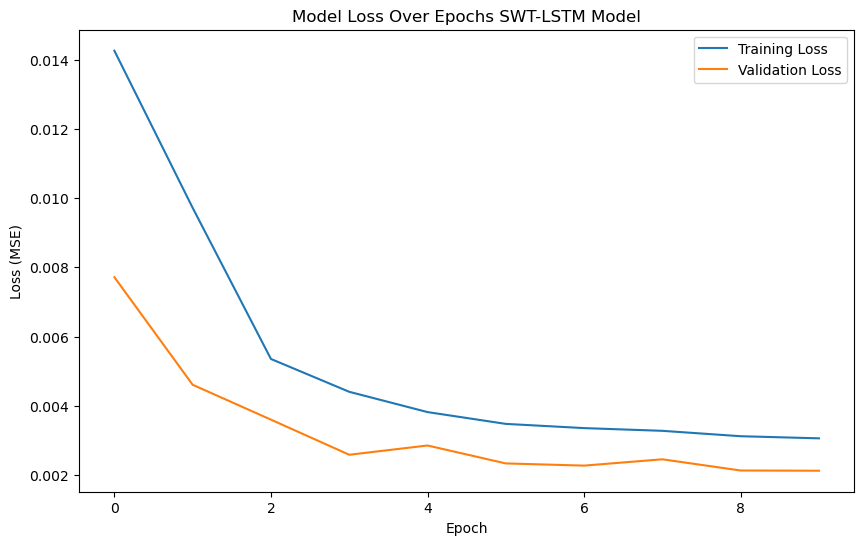

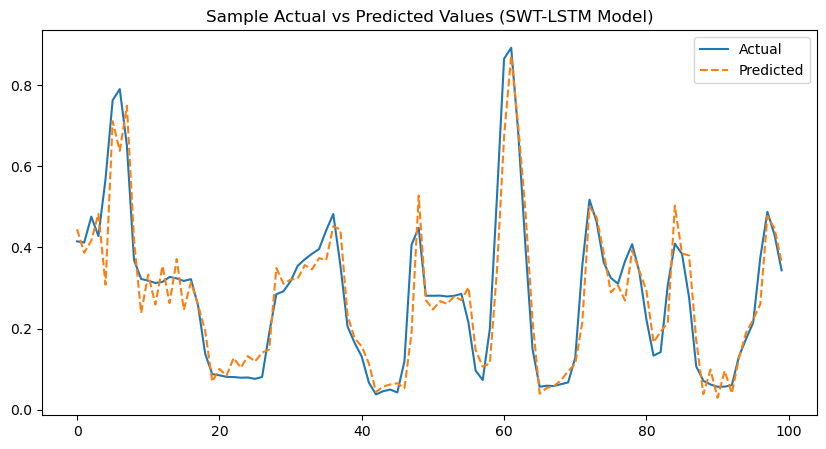

In [14]:
# Ploting the training and validation loss over epochs to visualize the model's learning process
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs SWT-LSTM Model')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Ploting the actual vs predicted values for better visual understanding of the model's performance
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[:100], label='Actual')
plt.plot(y_pred_rescaled[:100], label='Predicted', linestyle='dashed')
plt.legend()
plt.title("Sample Actual vs Predicted Values (SWT-LSTM Model)")
plt.show()


In [15]:
from sklearn.model_selection import KFold
import numpy as np

# Defining a function to create the LSTM model for cross-validation
def create_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Manual cross-validation using KFold to evaluate model performance
kf = KFold(n_splits=5)
rmse_scores = []

for train_index, val_index in kf.split(X_train_reshaped):
    X_train_cv, X_val_cv = X_train_reshaped[train_index], X_train_reshaped[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    model = create_model()
    model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, verbose=0)
    
    y_val_pred = model.predict(X_val_cv)
    y_val_pred_rescaled = scaler.inverse_transform(y_val_pred)
    y_val_rescaled = scaler.inverse_transform(y_val_cv.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_val_rescaled, y_val_pred_rescaled))
    rmse_scores.append(rmse)

print(f"Cross-validated RMSE: {np.mean(rmse_scores)}")


c:\Users\glawi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\glawi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


c:\Users\glawi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\glawi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\glawi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Cross-validated RMSE: 0.07022027215423213


## Anomaly Detection Using AI Techniques
### Make Predictions and Inverse Scale

In [16]:
# Generatepredictions using the LSTM model
y_pred = model.predict(X_test_reshaped)

# Inverse scaling to return predictions back to the original scale for anomaly detection
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Checking the shape of the predicted and actual values to ensure consistency
print(f"y_pred_rescaled shape: {y_pred_rescaled.shape}, y_test_rescaled shape: {y_test_rescaled.shape}")

# Calculating residuals (actual - predicted) to identify potential anomalies
residuals = y_test_rescaled.flatten() - y_pred_rescaled.flatten()

# Add the residuals and forecasts back to the original DataFrame for analysis
df_scaled['Forecast'] = np.nan
df_scaled.iloc[-len(y_pred_rescaled):, df_scaled.columns.get_loc('Forecast')] = y_pred_rescaled.flatten()
df_scaled['Residuals'] = np.nan
df_scaled.iloc[-len(residuals):, df_scaled.columns.get_loc('Residuals')] = residuals


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
y_pred_rescaled shape: (6880, 1), y_test_rescaled shape: (6880, 1)


## Isolation Forest for Anomaly Detection

In [17]:
from sklearn.ensemble import IsolationForest

# Applying Isolation Forest to detect anomalies in residuals
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_scaled['Anomaly'] = np.nan  # Initialize a column for anomalies

# Detect anomalies based on residuals using Isolation Forest
anomaly_predictions = iso_forest.fit_predict(df_scaled[['Residuals']].dropna().values.reshape(-1, 1))

# Adding anomaly detection results to the DataFrame
df_scaled.iloc[-len(anomaly_predictions):, df_scaled.columns.get_loc('Anomaly')] = anomaly_predictions

# Converting anomaly labels (-1 for anomaly, 1 for normal) to a more readable format
df_scaled['Anomaly'] = df_scaled['Anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# Checking the anomaly column to see the detected anomalies
print(df_scaled[['Residuals', 'Anomaly']].tail())


                     Residuals  Anomaly
Datetime                               
2010-11-26 17:00:00   0.014529   Normal
2010-11-26 18:00:00  -0.017797   Normal
2010-11-26 19:00:00  -0.029760   Normal
2010-11-26 20:00:00   0.016758   Normal
2010-11-26 21:00:00   0.498258  Anomaly


## Autoencoders for Anomaly Detection

In [18]:
from keras.models import Model
from keras.layers import Input, Dense

# Define the Autoencoder architecture for unsupervised anomaly detection
input_dim = X_train_reshaped.shape[1]  # Number of features (after SWT)
encoding_dim = 32  # Bottleneck layer

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoding layers
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)

# Decoding layers
decoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder on the training data
autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=50, batch_size=32, validation_data=(X_test_reshaped, X_test_reshaped))

# Calculating reconstruction errors on the test set
X_test_pred = autoencoder.predict(X_test_reshaped)

# Reshaping the predictions to match the original input shape
X_test_pred_reshaped = X_test_pred.reshape(X_test_reshaped.shape)

# Calculating the reconstruction error (difference between input and reconstructed output)
reconstruction_errors = np.mean(np.abs(X_test_reshaped - X_test_pred_reshaped), axis=1)

# Define a threshold for anomalies (e.g., based on the 95th percentile of the reconstruction errors)
threshold = np.percentile(reconstruction_errors, 95)

# Flag data points as anomalies if their reconstruction error exceeds the threshold
anomalies_autoencoder = reconstruction_errors > threshold
df_scaled['Anomaly_Autoencoder'] = np.nan
df_scaled.iloc[-len(anomalies_autoencoder):, df_scaled.columns.get_loc('Anomaly_Autoencoder')] = anomalies_autoencoder


Epoch 1/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 967us/step - loss: 0.0421 - val_loss: 0.0031
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - loss: 0.0041 - val_loss: 0.0022
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 7/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 0.0013 - val_loss: 9.1905e-04
Epoch 8/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - loss: 0.0012 - val_loss: 8.6358e-04
Epoch 9/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 0.0011 - val_loss: 7.9821e-04
Epoch 10/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - loss: 0.0010 - val_loss: 7.6795e-04
Epoch 11/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - loss: 9.6562e-04 - val_loss: 7.1787e-04
Epoch 

## One-Class SVM

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Flatten the 3D data to 2D for One-Class SVM
X_train_flattened = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)  # Flatten (samples, time steps * features)
X_test_flattened = X_test_reshaped.reshape(X_test_reshaped.shape[0], -1)  # Flatten (samples, time steps * features)

# Scaling the flattened data using StandardScaler for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Training One-Class SVM for anomaly detection with adjusted parameters
oc_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.05)  # Adjust nu and gamma for sensitivity
oc_svm.fit(X_train_scaled)

# Predicting anomalies on the test set using the trained One-Class SVM
anomalies_svm = oc_svm.predict(X_test_scaled)

# Converting SVM results to the DataFrame
df_scaled['Anomaly_SVM'] = np.nan
df_scaled.iloc[-len(anomalies_svm):, df_scaled.columns.get_loc('Anomaly_SVM')] = anomalies_svm

# Converting -1 to 'Anomaly' and 1 to 'Normal' for readability
df_scaled['Anomaly_SVM'] = df_scaled['Anomaly_SVM'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# Counting the number of detected anomalies for reference
num_anomalies = (anomalies_svm == -1).sum()
print(f"Number of anomalies detected by One-Class SVM: {num_anomalies}")


Number of anomalies detected by One-Class SVM: 48


## Local Outlier Factor (LOF)

In [20]:
from sklearn.neighbors import LocalOutlierFactor

# Flatten the 3D data to 2D for LOF (as LOF expects 2D data)
X_test_flattened = X_test_reshaped.reshape(X_test_reshaped.shape[0], -1)

# Training LOF for anomaly detection, adjusting contamination as needed
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
anomalies_lof = lof.fit_predict(X_test_flattened)

# Converting LOF results to your DataFrame for further analysis
df_scaled['Anomaly_LOF'] = np.nan
df_scaled.iloc[-len(anomalies_lof):, df_scaled.columns.get_loc('Anomaly_LOF')] = anomalies_lof

# Converting -1 to 'Anomaly' and 1 to 'Normal' for better readability
df_scaled['Anomaly_LOF'] = df_scaled['Anomaly_LOF'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')



## Visualizing and Comparing Anomalies

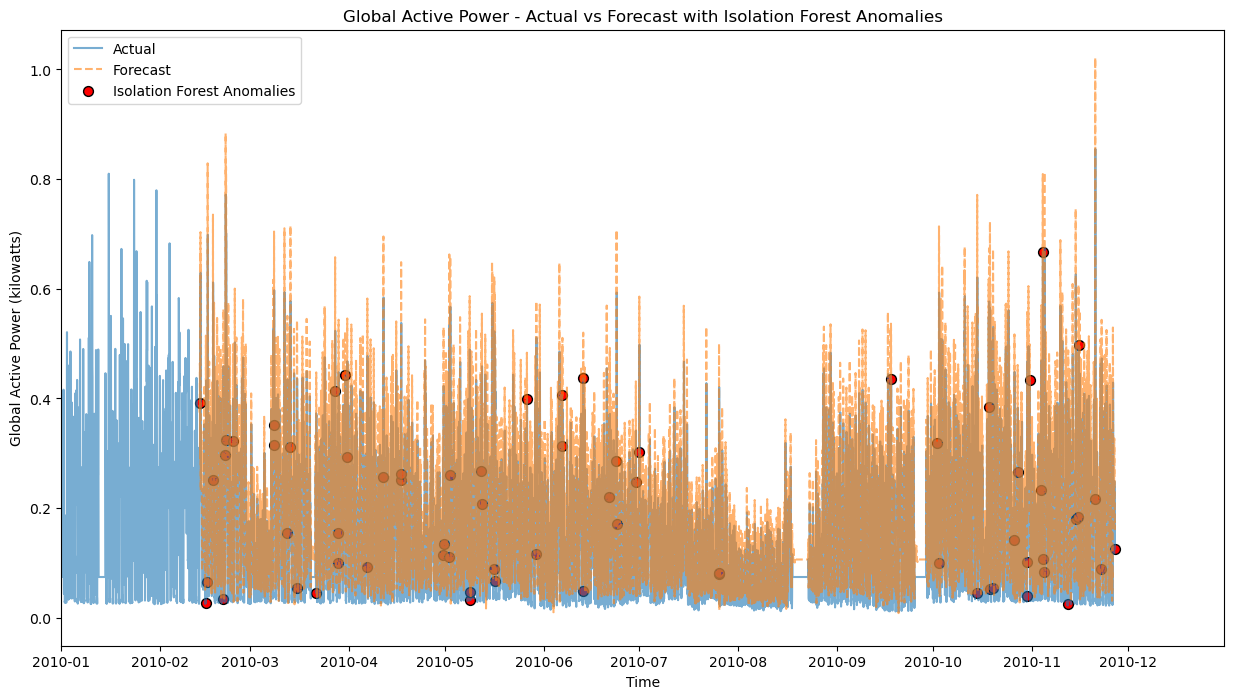

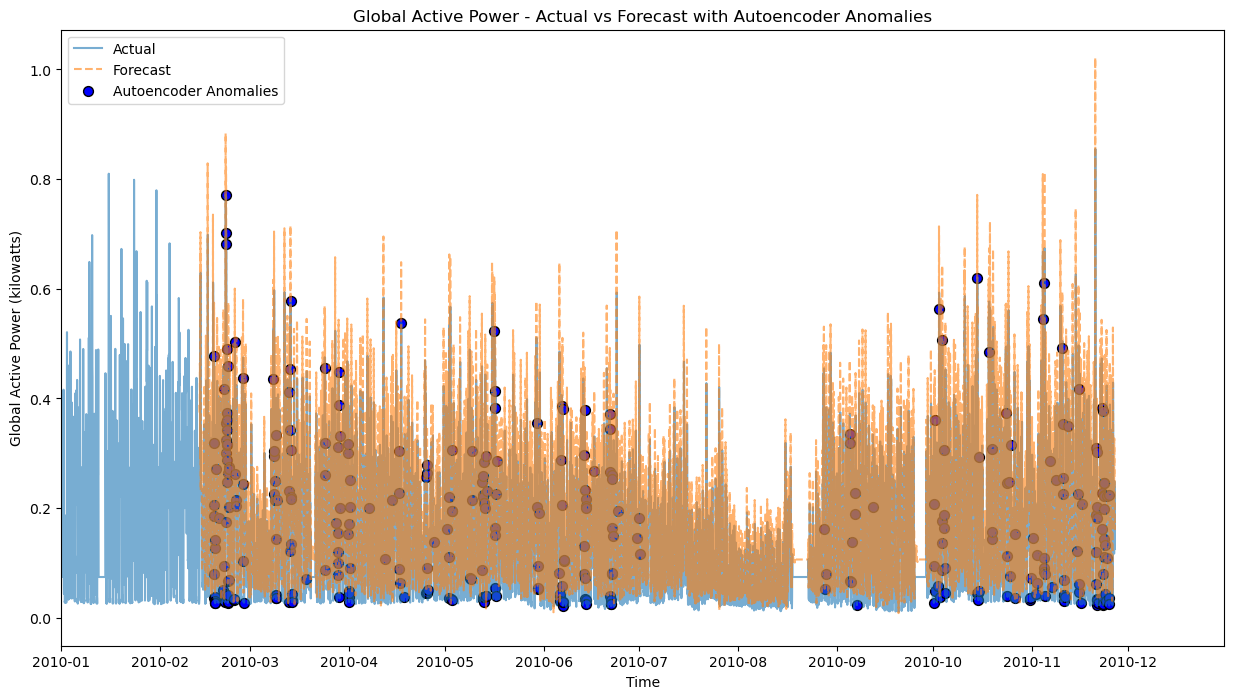

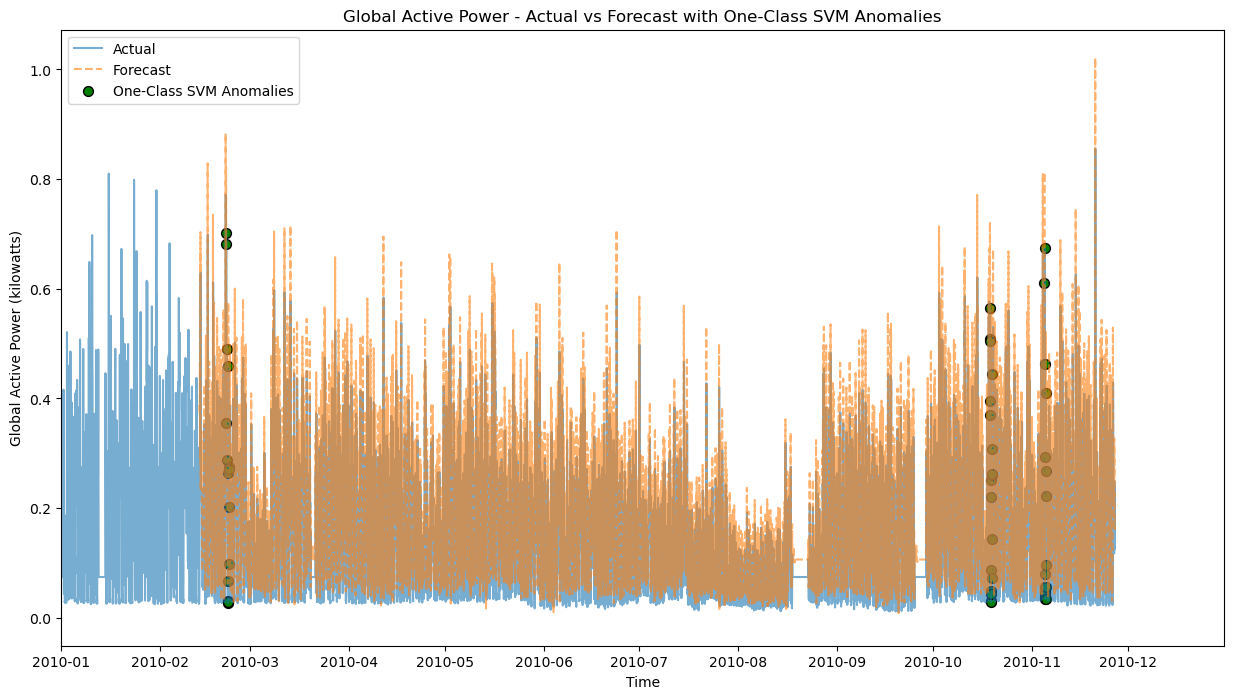

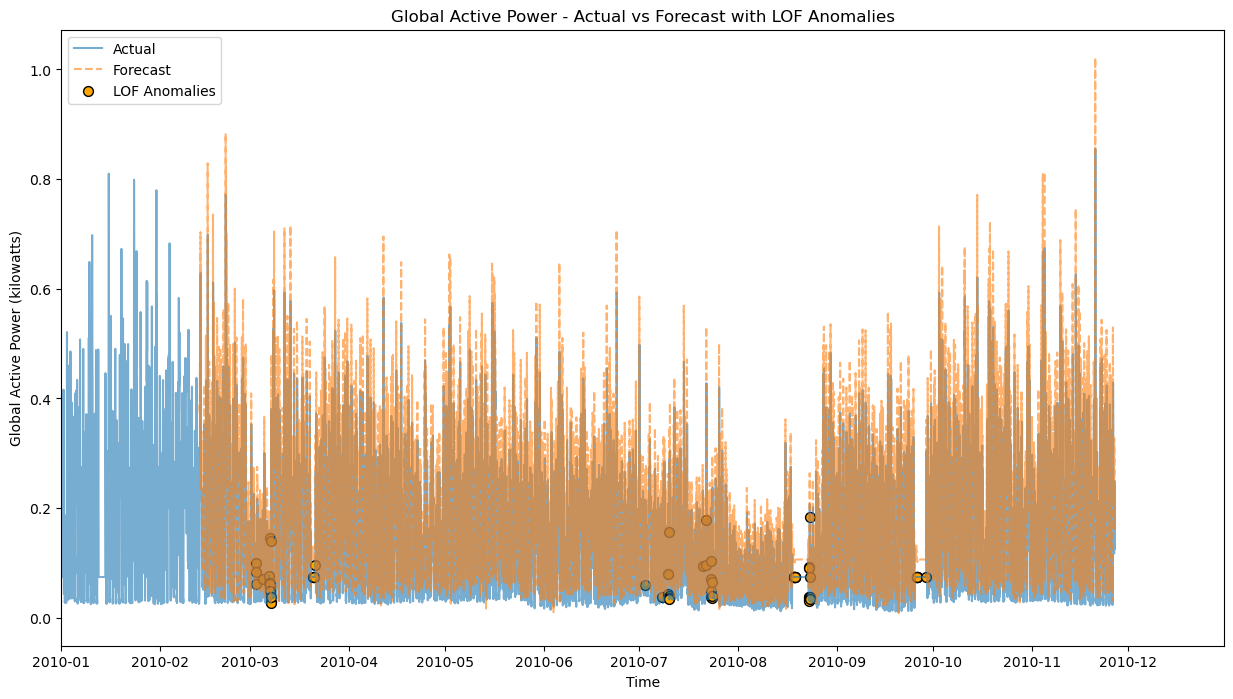

In [21]:
import matplotlib.pyplot as plt

# Isolation Forest Anomalies Visualization
plt.figure(figsize=(15, 8))

# Ploting actual vs forecast values
plt.plot(df_scaled.index, df_scaled['Global_active_power'], label='Actual', alpha=0.6)
plt.plot(df_scaled.index, df_scaled['Forecast'], label='Forecast', linestyle='dashed', alpha=0.6)

# Highlight anomalies detected by Isolation Forest
plt.scatter(df_scaled.index[df_scaled['Anomaly'] == 'Anomaly'], 
            df_scaled['Global_active_power'][df_scaled['Anomaly'] == 'Anomaly'], 
            color='red', label='Isolation Forest Anomalies', s=50, edgecolor='black')

plt.title('Global Active Power - Actual vs Forecast with Isolation Forest Anomalies')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()

# Zooming in on a specific time period
plt.xlim(pd.Timestamp('2010-01-01'), pd.Timestamp('2010-12-31'))  

plt.show()

# Autoencoder Anomalies Visualization
plt.figure(figsize=(15, 8))

# Ploting actual vs forecast values
plt.plot(df_scaled.index, df_scaled['Global_active_power'], label='Actual', alpha=0.6)
plt.plot(df_scaled.index, df_scaled['Forecast'], label='Forecast', linestyle='dashed', alpha=0.6)

# Highlighting anomalies detected by Autoencoder
plt.scatter(df_scaled.index[df_scaled['Anomaly_Autoencoder'] == True], 
            df_scaled['Global_active_power'][df_scaled['Anomaly_Autoencoder'] == True], 
            color='blue', label='Autoencoder Anomalies', s=50, edgecolor='black')

plt.title('Global Active Power - Actual vs Forecast with Autoencoder Anomalies')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()

# Zooming in on a specific time period
plt.xlim(pd.Timestamp('2010-01-01'), pd.Timestamp('2010-12-31'))  

plt.show()

# One-Class SVM Anomalies Visualization
plt.figure(figsize=(15, 8))

# Ploting actual vs forecast values
plt.plot(df_scaled.index, df_scaled['Global_active_power'], label='Actual', alpha=0.6)
plt.plot(df_scaled.index, df_scaled['Forecast'], label='Forecast', linestyle='dashed', alpha=0.6)

# Highlighting anomalies detected by One-Class SVM
plt.scatter(df_scaled.index[df_scaled['Anomaly_SVM'] == 'Anomaly'], 
            df_scaled['Global_active_power'][df_scaled['Anomaly_SVM'] == 'Anomaly'], 
            color='green', label='One-Class SVM Anomalies', s=50, edgecolor='black')

plt.title('Global Active Power - Actual vs Forecast with One-Class SVM Anomalies')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()

# Zooming in on a specific time period
plt.xlim(pd.Timestamp('2010-01-01'), pd.Timestamp('2010-12-31'))  

plt.show()

# Local Outlier Factor (LOF) Anomalies Visualization
plt.figure(figsize=(15, 8))

# Ploting actual vs forecast values
plt.plot(df_scaled.index, df_scaled['Global_active_power'], label='Actual', alpha=0.6)
plt.plot(df_scaled.index, df_scaled['Forecast'], label='Forecast', linestyle='dashed', alpha=0.6)

# Highlighting anomalies detected by LOF
plt.scatter(df_scaled.index[df_scaled['Anomaly_LOF'] == 'Anomaly'], 
            df_scaled['Global_active_power'][df_scaled['Anomaly_LOF'] == 'Anomaly'], 
            color='orange', label='LOF Anomalies', s=50, edgecolor='black')

plt.title('Global Active Power - Actual vs Forecast with LOF Anomalies')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()

# Zooming in on a specific time period
plt.xlim(pd.Timestamp('2010-01-01'), pd.Timestamp('2010-12-31'))  
plt.show()


